# 07 - Beyond Confounders

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import os
import typing

style.use("fivethirtyeight")

## Good Controls

#### Get the Data

In [2]:
data_path = './collections_email.csv'
data_url = 'https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/collections_email.csv'
if os.path.exists(data_path):
    data = pd.read_csv(data_path)
else:
    data = pd.read_csv(data_url)
    data.to_csv(data_path)

data.head()

,Unnamed: 0,payments,email,opened,agreement,credit_limit,risk_score
0,0,740,1,1.0,0.0,2348.495260,0.666752
1,1,580,1,1.0,1.0,334.111969,0.207395
2,2,600,1,1.0,1.0,1360.660722,0.550479
3,3,770,0,0.0,0.0,1531.828576,0.560488
4,4,660,0,0.0,0.0,979.855647,0.455140


In [3]:
len(data)

5000

In [4]:
data.groupby('email').payments.mean()

email
0    669.976434
1    669.356153
Name: payments, dtype: float64

<Axes: xlabel='email', ylabel='payments'>

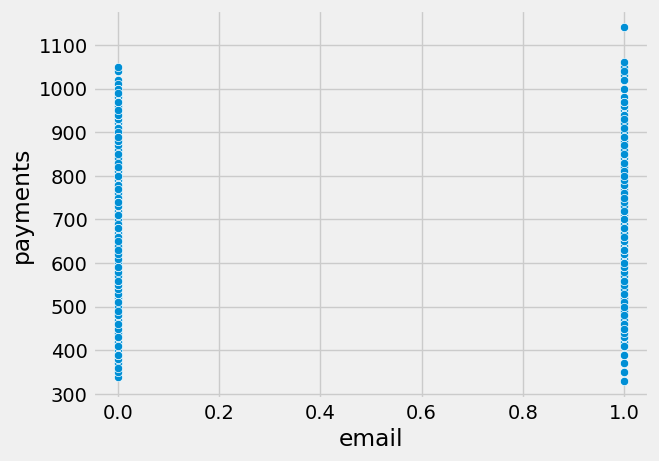

In [5]:
sns.scatterplot(x=data.email, y=data.payments)

<Axes: xlabel='payments', ylabel='Count'>

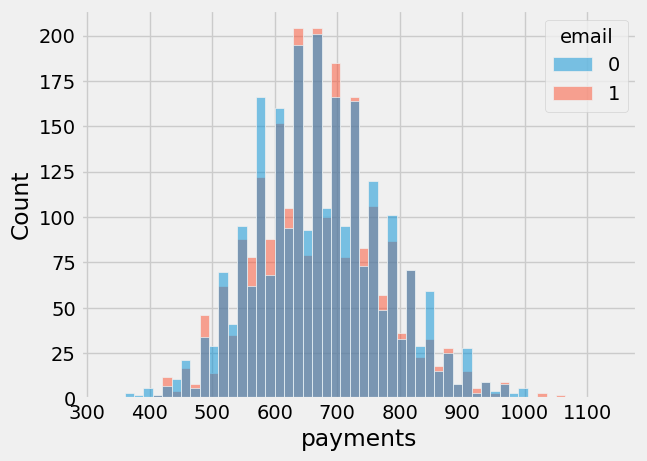

In [6]:
sns.histplot(data, x='payments', hue='email')

In [10]:
stats.ttest_ind(data.payments[data.email == 0], data.payments[data.email == 1])

TtestResult(statistic=np.float64(0.21087238565395539), pvalue=np.float64(0.8329954493440059), df=np.float64(4998.0))

In [11]:
stats.pearsonr(data.payments, data.email)

PearsonRResult(statistic=np.float64(-0.002982769224577615), pvalue=np.float64(0.832995449344006))

<Axes: xlabel='email', ylabel='payments'>

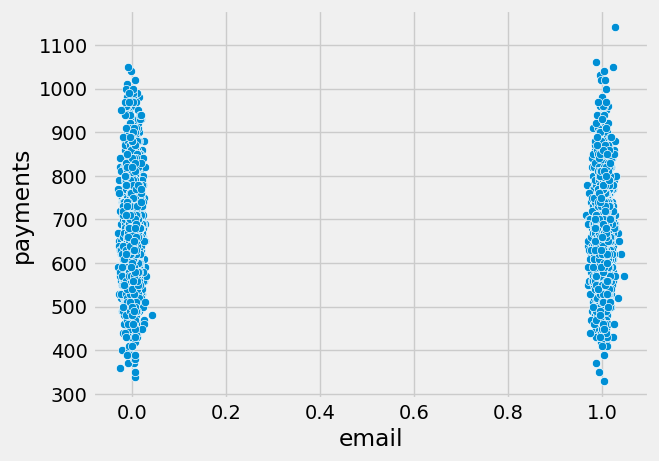

In [13]:
sns.scatterplot(x=data.email + np.random.normal(0, 0.01, len(data)), y=data.payments)

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(data[['email', 'credit_limit', 'risk_score']].to_numpy(), data.payments)
model.coef_

array([ 4.43035568,  0.15106862, -8.05157756])

In [17]:
naive = LinearRegression().fit(data[['email']].to_numpy(), data.payments)
naive.coef_

array([-0.6202804])

Text(0.5, 1.0, 'Controlled regression, $\\beta_1 = 4.430$')

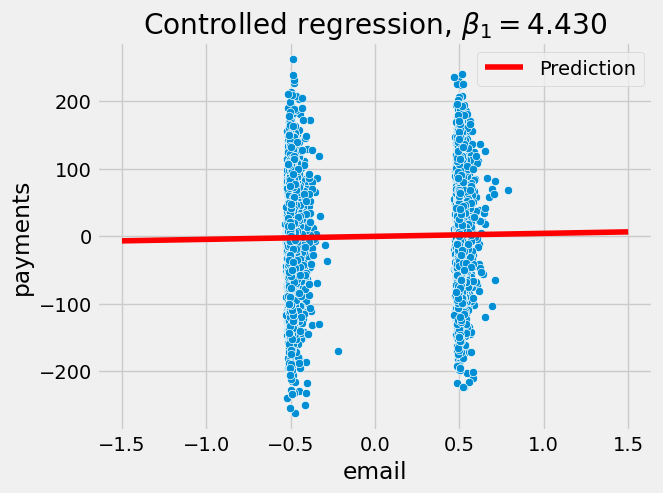

In [30]:
email_model = LinearRegression().fit(data[['credit_limit', 'risk_score']].to_numpy(), data.email)
payments_model = LinearRegression().fit(data[['credit_limit', 'risk_score']].to_numpy(), data.payments)

email_res = data.email - email_model.predict(data[['credit_limit', 'risk_score']].to_numpy())
payments_res = data.payments - payments_model.predict(data[['credit_limit', 'risk_score']].to_numpy())

res_model = LinearRegression().fit(email_res.to_numpy().reshape(-1, 1), payments_res)

indent = 0.5
x = np.linspace(-1 - indent, 1 + indent, 10)
pred = res_model.predict(x.reshape(-1, 1))

sns.scatterplot(x=email_res, y=payments_res)
sns.lineplot(x=x, y=pred, label="Prediction", c='r')
plt.title(fr"Controlled regression, $\beta_1 = {res_model.coef_[0]:.3f}$")

## Mostly Harmful Controls

In [31]:
hospital_data_url = 'https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/hospital_treatment.csv'
hospital_data_path = './hospital_treatment.csv'

if os.path.exists(hospital_data_path):
    ht = pd.read_csv(hospital_data_path)
else:
    ht = pd.read_csv(hospital_data_url)
    ht.to_csv(hospital_data_path)

ht.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [33]:
both = LinearRegression().fit(ht[['treatment']], ht.days)
first = LinearRegression().fit(ht[ht.hospital==0][['treatment']], ht[ht.hospital==0].days)
second = LinearRegression().fit(ht[ht.hospital==1][['treatment']], ht[ht.hospital==1].days)

both.coef_[0], first.coef_[0], second.coef_[0]

(np.float64(14.153333333333334),
 np.float64(-11.407407407407412),
 np.float64(-10.395833333333334))